In [6]:
import os

import numpy as np
import pandas as pd
import spikeextractors as se
import spiketoolkit as st
import spikewidgets as sw

import tqdm.notebook as tqdm
from scipy.signal import periodogram, spectrogram

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import panel as pn
import panel.widgets as pnw

pn.extension()

from utils import *

In [44]:
# Path to the data folder in the repo
data_path = r'C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/2021-02-15_21-59-19_Or179_Or177_overnight'

# Path to the raw data in the hard drive
with open(os.path.join(data_path, 'LFP_location.txt')) as f:    
    OE_data_path = f.read()

### Get each bird's recording, and their microphone channels

In [45]:
# Whole recording from the hard drive
recording = se.BinDatRecordingExtractor(OE_data_path,30000,40, dtype='int16')

# Note I am adding relevant ADC channels
# First bird
Or179_recording = se.SubRecordingExtractor(recording,channel_ids=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15, 32])

# Second bird
Or177_recording = se.SubRecordingExtractor(recording,channel_ids=[16, 17,18,19,20,21,22,23,24,25,26,27,28,29,30,31, 33])

# Bandpass fiter microphone recoridngs
mic_recording = st.preprocessing.bandpass_filter(
    se.SubRecordingExtractor(recording,channel_ids=[32,33]),
    freq_min=500,
    freq_max=1400
)

In [65]:
# Get wav files
wav_names = [file_name for file_name in os.listdir(data_path) if file_name.endswith('.wav') and ('Or179' in file_name)]
wav_paths = [os.path.join(data_path,wav_name) for wav_name in wav_names]

# Get tranges for wav files in the actual recording
# OE_data_path actually contains the path all the way to the .bin. We just need the parent directory
# with the timestamp.

# Split up the path
OE_data_path_split= OE_data_path.split(os.sep)

# Take only the first three. os.path is weird so we manually add the separator after the 
# drive name.
OE_parent_path = os.path.join(OE_data_path_split[0] + os.sep, *OE_data_path_split[1:3])

# Get all time ranges given the custom offset.
# NOTE: recording was taken BEFORE synchronizing computers, so it is going to be using a custom offset
tranges=np.array([
    get_trange(OE_parent_path, path, offset=datetime.timedelta(minutes=5, seconds=44), duration=3) 
    for path in wav_paths])


In [66]:
wav_df = pd.DataFrame({'wav_paths':wav_paths, 'wav_names':wav_names, 'trange0':tranges[:, 0], 'trange1':tranges[:, 1]})
wav_df.head()

,wav_paths,wav_names,trange0,trange1
0,C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...,Or179_44243.17760767_2_16_4_56_0.wav,25343.5,25346.5
1,C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...,Or179_44243.27661291_2_16_7_41_1.wav,35244.5,35247.5
2,C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...,Or179_44243.27840879_2_16_7_44_0.wav,35423.5,35426.5
3,C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...,Or179_44243.27845564_2_16_7_44_5.wav,35428.5,35431.5
4,C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/...,Or179_44243.28638226_2_16_7_57_18.wav,36221.5,36224.5


Connect the wav files to the recording

In [67]:
wav_f,_,_,_=wav_df.loc[0,:]
wav_f

'C:/Users/danpo/Documents/LoisLFP/LoisLFP/data/2021-02-15_21-59-19_Or179_Or177_overnight\\Or179_44243.17760767_2_16_4_56_0.wav'

In [61]:
'Or177_44243.22571081_2_16_6_16_11.wav', data_path
datetime.datetime(2021,2,16,6,16,11) - datetime.datetime(2021, 2, 15,21,59,19) 

datetime.timedelta(seconds=29812)

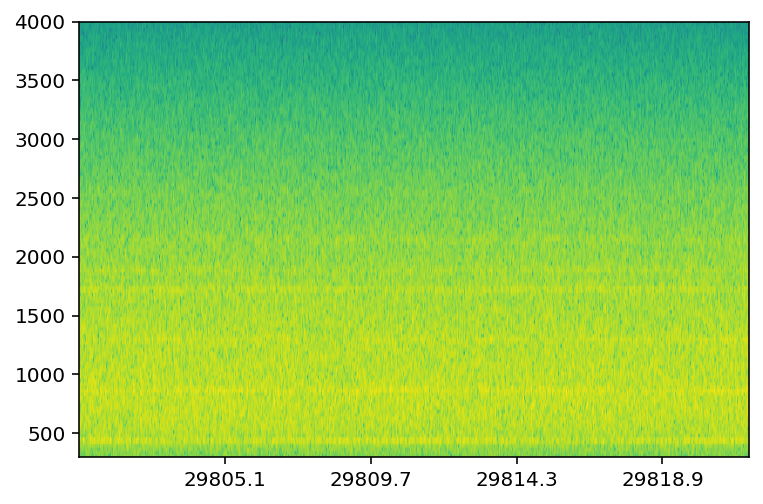

In [64]:
paths, name, tr0, tr1 = wav_df.loc[0,:]
sw.plot_spectrogram(mic_recording, trange= [tr0-10,tr1+10], freqrange=[300,4000], nfft=2**10, channel=33)

Dashboarding. Based on https://coderzcolumn.com/tutorials/data-science/how-to-create-dashboard-using-python-matplotlib-panel.

In [55]:
# Set up widgets
wav_selector = pnw.Select(options=list(range(len(wav_df))), name="Select song file")
# offset_selector = pnw.Select(options=np.linspace(-10,10,21).tolist(), name="Select offset")
window_radius_selector = pnw.Select(options=[10,20,30,40,60], name="Select window radius")
spect_chan_selector = pnw.Select(options=list(range(16)), name="Spectrogram channel")
spect_freq_lo = pnw.Select(options=np.linspace(0,130,14).tolist(), name="Low frequency for spectrogram (Hz)")
spect_freq_hi = pnw.Select(options=np.linspace(130,0,14).tolist(), name="Hi frequency for spectrogram (Hz)")
log_nfft_selector = pnw.Select(options=np.linspace(10,16,7).tolist(), name="magnitude of nfft (starts at 256)")

@pn.depends(
    wav_selector=wav_selector.param.value,
#     offset=offset_selector.param.value,
    window_radius=window_radius_selector.param.value,
    spect_chan=spect_chan_selector.param.value,
    spect_freq_lo=spect_freq_lo.param.value,
    spect_freq_hi=spect_freq_hi.param.value,
    log_nfft=log_nfft_selector.param.value
)
def create_figure(wav_selector, 
#                   offset,
                  window_radius, spect_chan,
                  spect_freq_lo, spect_freq_hi, log_nfft):
    
    # Each column in each row to a tuple that we unpack
    wav_file_path, wav_file_name, tr0, tr1 = wav_df.loc[wav_selector,:]
    print(wav_file_name)
    # Set up figure
    fig,axes = plt.subplots(4,1, figsize=(16,12))
    
    # Get wav file numpy recording object
    wav_recording = get_wav_recording(wav_file_path)
    
    # Apply offset and apply window radius
    offset = 0
    tr0 = tr0+ offset-window_radius
    # Add duration of wav file
    tr1 = tr1+ offset+window_radius+wav_recording.get_num_frames()/wav_recording.get_sampling_frequency()
    
    
    '''Plot sound spectrogram (Hi fi mic)'''
    sw.plot_spectrogram(wav_recording, channel=0, freqrange=[300,14000],ax=axes[0])
    axes[0].set_title('Hi fi mic spectrogram')
    
    '''Plot sound spectrogram (Lo fi mic)''' 
    if 'Or179' in wav_file_name:
        LFP_recording = Or179_recording
    elif 'Or177' in wav_file_name:
        LFP_recording = Or177_recording
    
    mic_channel = LFP_recording.get_channel_ids()[-1]
    
    sw.plot_spectrogram(
        mic_recording,
        mic_channel,
        trange=[tr0, tr1],
        freqrange=[600,4000],
        ax=axes[1]
    )
    
    axes[1].set_title('Lo fi mic spectrogram')
    
    '''Plot LFP timeseries'''
    chan_ids = np.array([LFP_recording.get_channel_ids()]).flatten()
    sw.plot_timeseries(
        LFP_recording,
        channel_ids=chan_ids[1:4],
        trange=[tr0, tr1],
        ax=axes[2]
    )
    axes[2].set_title('Raw LFP')
    
    # Clean lines
    for line in plt.gca().lines:
        line.set_linewidth(0.5)    
    
    '''Plot LFP spectrogram'''
    sw.plot_spectrogram(
        LFP_recording,
        channel=chan_ids[spect_chan],
        freqrange=[spect_freq_lo,spect_freq_hi],
        trange=[tr0, tr1],
        ax=axes[3],
        nfft=int(2**log_nfft)
    )
    axes[3].set_title('LFP')
    
    for i, ax in enumerate(axes):
        ax.set_yticks([ax.get_ylim()[1]])
        ax.set_yticklabels([ax.get_ylim()[1]])
        ax.set_xlabel('')
        
    # Show 30 Hz
    ax.set_yticks([30, ax.get_ylim()[1]])
    ax.set_yticklabels([30, ax.get_ylim()[1]])
            
    
    return fig

Or177_44243.22571081_2_16_6_16_11.wav


C:\Users\danpo\anaconda3\lib\site-packages\spikewidgets\widgets\spectrumwidget\spectrumwidget.py:179: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(np.linspace(self._trange[0], self._trange[1], l_xticks))


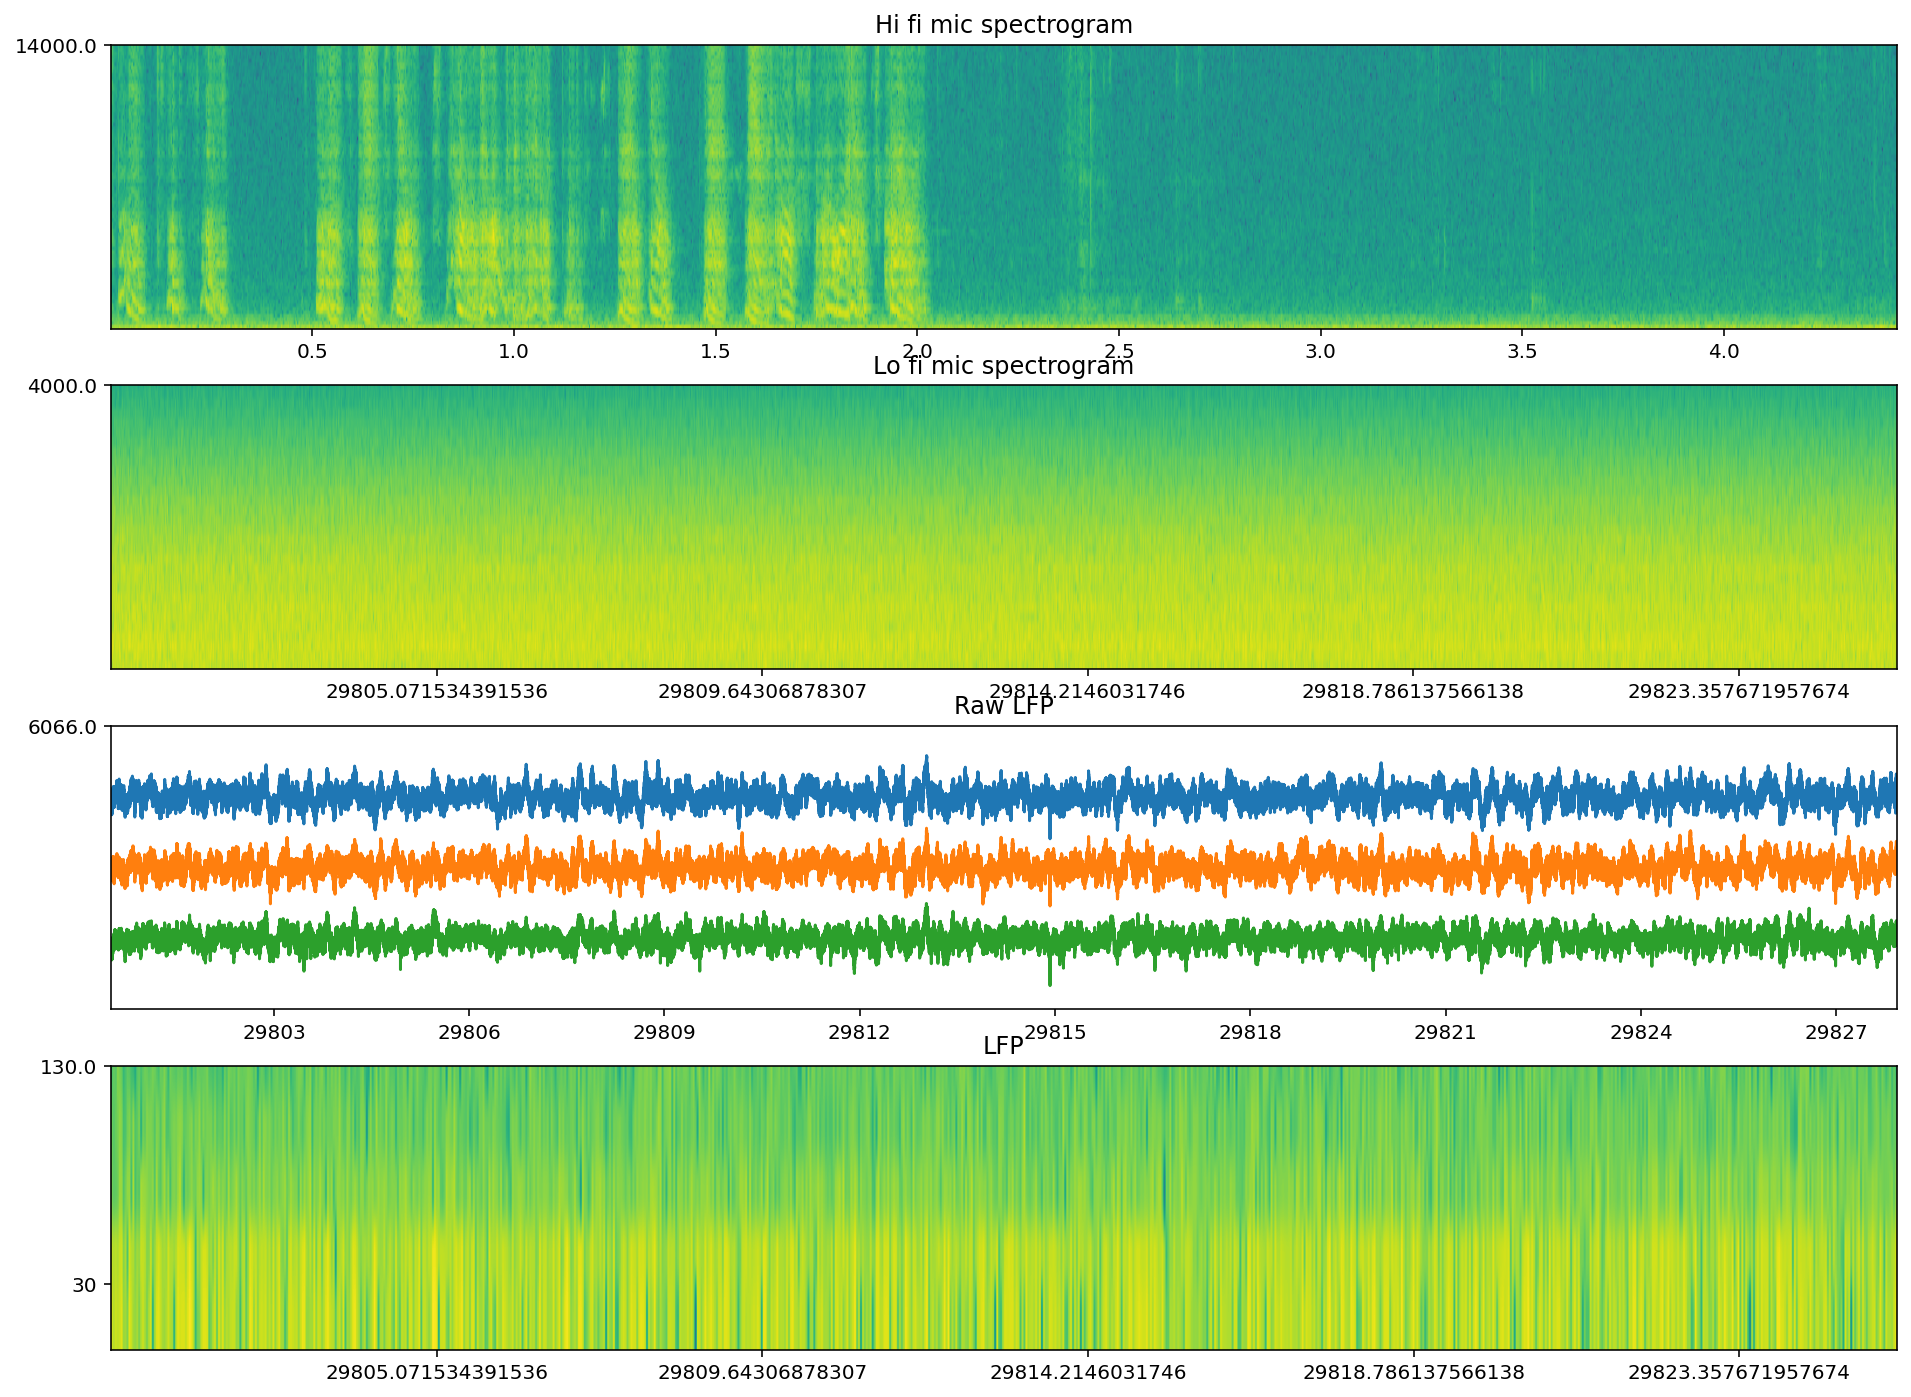

In [56]:
text = pnw.StaticText(value="<h3>OR179 degraded</h3>", align="center")
dash = pn.Column(
    text,
    pn.Row(wav_selector,
#            offset_selector,
           window_radius_selector,spect_chan_selector),
    pn.Row(spect_freq_lo,spect_freq_hi,log_nfft_selector),
    create_figure
);

Column
    [0] StaticText(align='center', value='<h3>OR179 degraded</h3>')
    [1] Row
        [0] Select(options=[0, 1, 2, 3, 4, ...], value=0)
        [1] Select(options=[10, 20, 30, 40, 60], value=10)
        [2] Select(name='Spectrogram channel', options=[0, 1, 2, 3, 4, ...], value=0)
    [2] Row
        [0] Select(name='Low frequency f..., options=[0.0, 10.0, 20.0, ...], value=0.0)
        [1] Select(name='Hi frequency f..., options=[130.0, 120.0, ...], value=130.0)
        [2] Select(name='magnitude of n..., options=[10.0, 11.0, 12.0, ...], value=10.0)
    [3] ParamFunction(function)
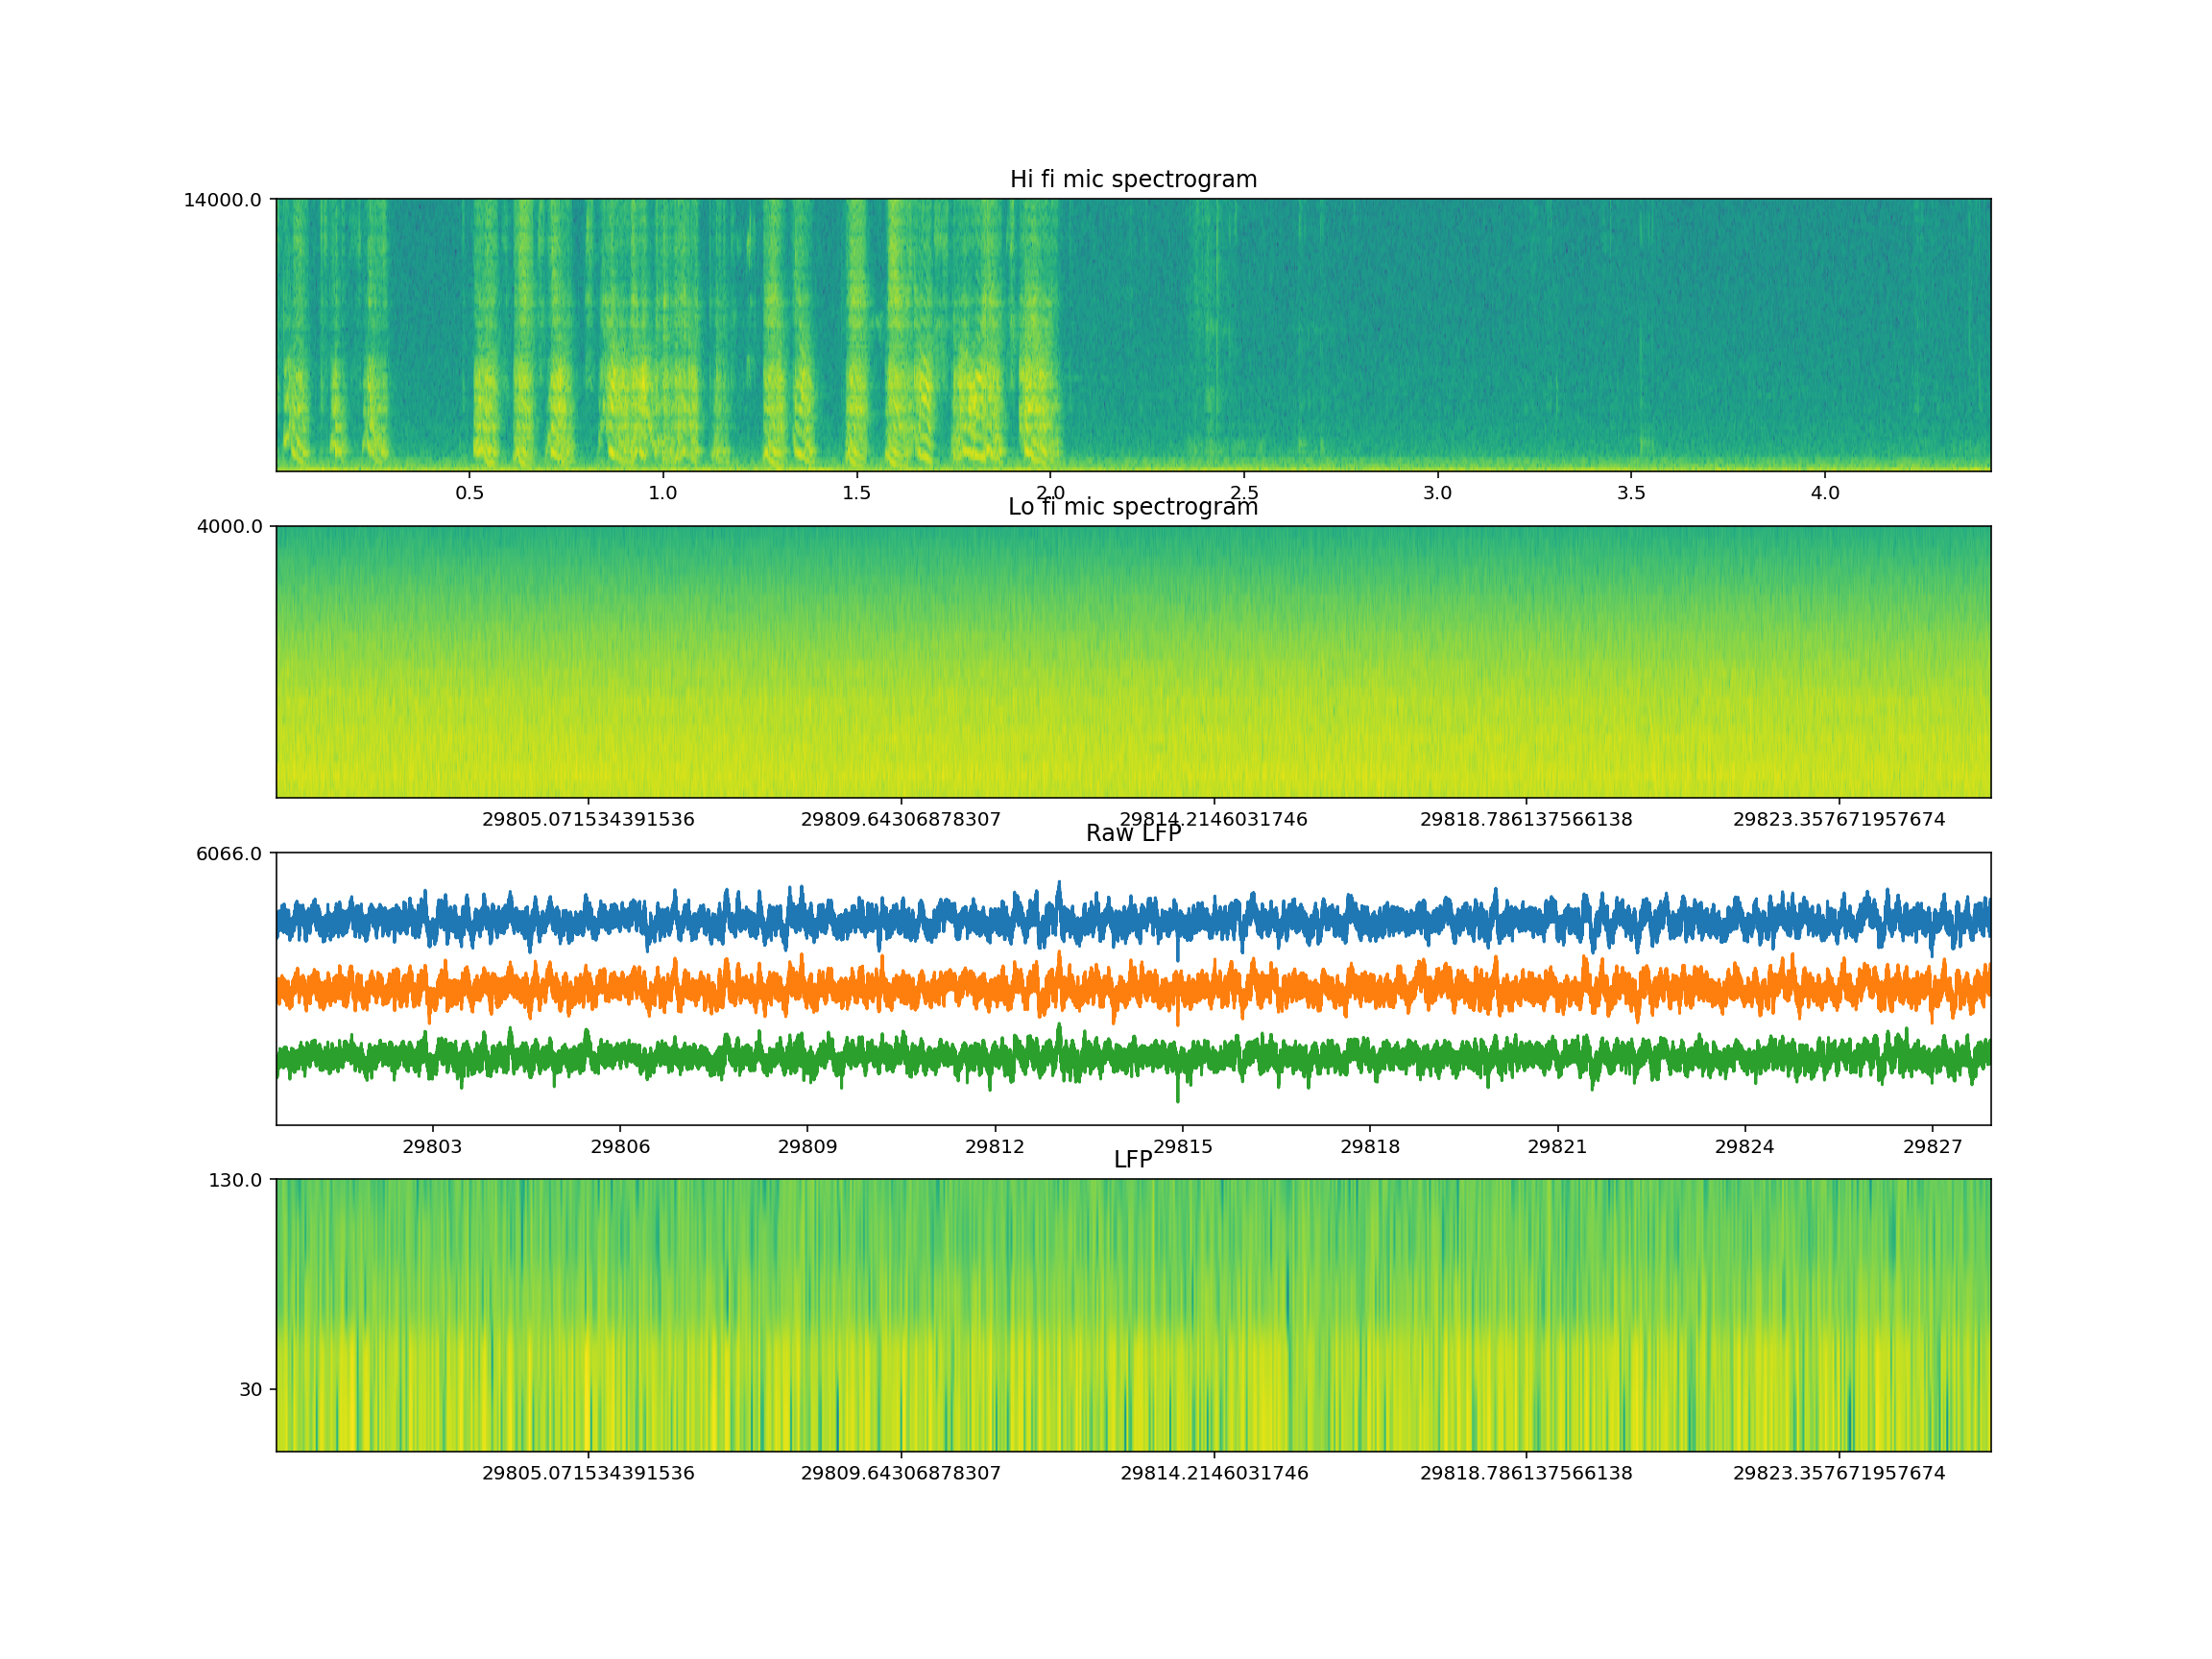

In [57]:
dash